# Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import xarray

# Load the dataset

In [13]:

path = r"../local_dataset/raw/fire/algeria_tunisia.csv"
dataset = pd.read_csv(path)

print("Shape of the dataset:", dataset.shape)
print("data types of the dataset:")
print(dataset.dtypes)
print("\n"*2)

dataset.info()
print("\n"*2)

dataset.describe()
print("\n"*2)

print(dataset.head())



Shape of the dataset: (90250, 15)
data types of the dataset:
latitude      float64
longitude     float64
bright_ti4    float64
scan          float64
track         float64
acq_date       object
acq_time        int64
satellite      object
instrument     object
confidence     object
version         int64
bright_ti5    float64
frp           float64
daynight       object
type            int64
dtype: object



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90250 entries, 0 to 90249
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    90250 non-null  float64
 1   longitude   90250 non-null  float64
 2   bright_ti4  90250 non-null  float64
 3   scan        90250 non-null  float64
 4   track       90250 non-null  float64
 5   acq_date    90250 non-null  object 
 6   acq_time    90250 non-null  int64  
 7   satellite   90250 non-null  object 
 8   instrument  90250 non-null  object 
 9   confidence  90250 non-null 

# Draw map 

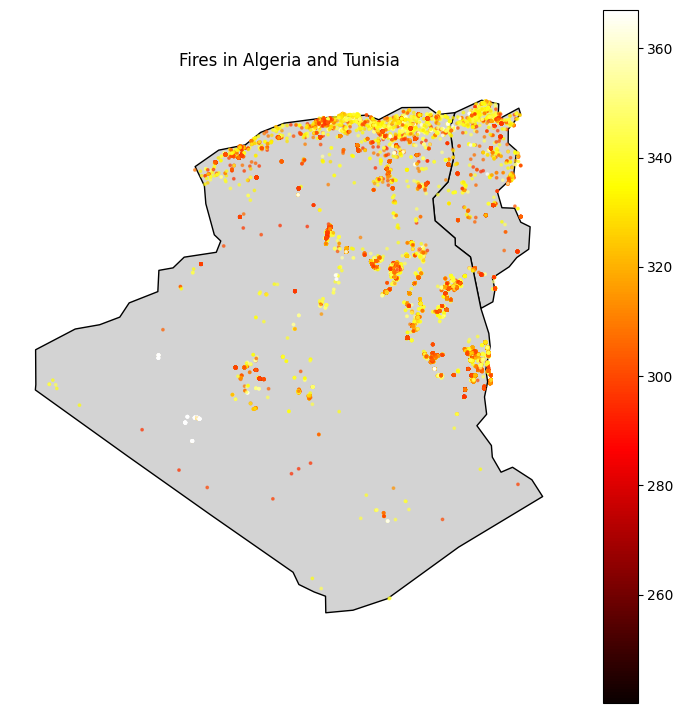

In [24]:
# Load the shapefile (country boundaries)
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile (country boundaries)
shp_path = r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shp_path)

# Select only Algeria and Tunisia
countries = world[world["ADMIN"].isin(["Algeria", "Tunisia"])]

# Convert countries to Web Mercator
countries = countries.to_crs(epsg=3857)

# Convert fires to GeoDataFrame and Web Mercator
fires = gpd.GeoDataFrame(dataset, 
                         geometry=gpd.points_from_xy(dataset.longitude, dataset.latitude),
                         crs='EPSG:4326')
fires = fires.to_crs(epsg=3857)

# Plot countries
ax = countries.plot(figsize=(9,9), color='lightgrey', edgecolor='black')

# Overlay fire points
fires.plot(ax=ax,
           column='bright_ti4',
           cmap='hot',
           markersize=3,
           alpha=0.6,
           legend=True)

ax.set_axis_off()
plt.title("Fires in Algeria and Tunisia")
plt.show()


# Remove useless features

In [14]:
dataset.drop(columns=["satellite", "instrument", "version", "scan", "track"], inplace=True)
dataset.rename(columns={"longitude": "lon", "latitude": "lat"}, inplace=True)
all_cols = dataset.drop(columns=["acq_date", "lon", "lat"])
print("Shape of the dataset after removing useless features:", all_cols.shape)

Shape of the dataset after removing useless features: (90250, 7)


# Feature analysis

=== Numeric columns ===
bright_ti4    float64
scan          float64
track         float64
acq_time        int64
bright_ti5    float64
frp           float64
type            int64
dtype: object
=== String columns ===
confidence    object
daynight      object
dtype: object


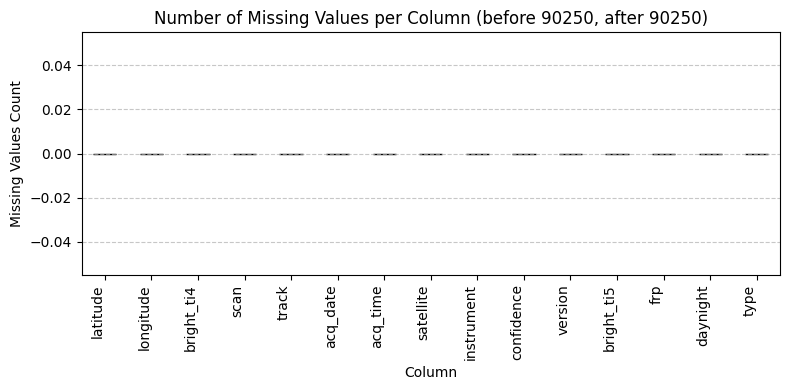

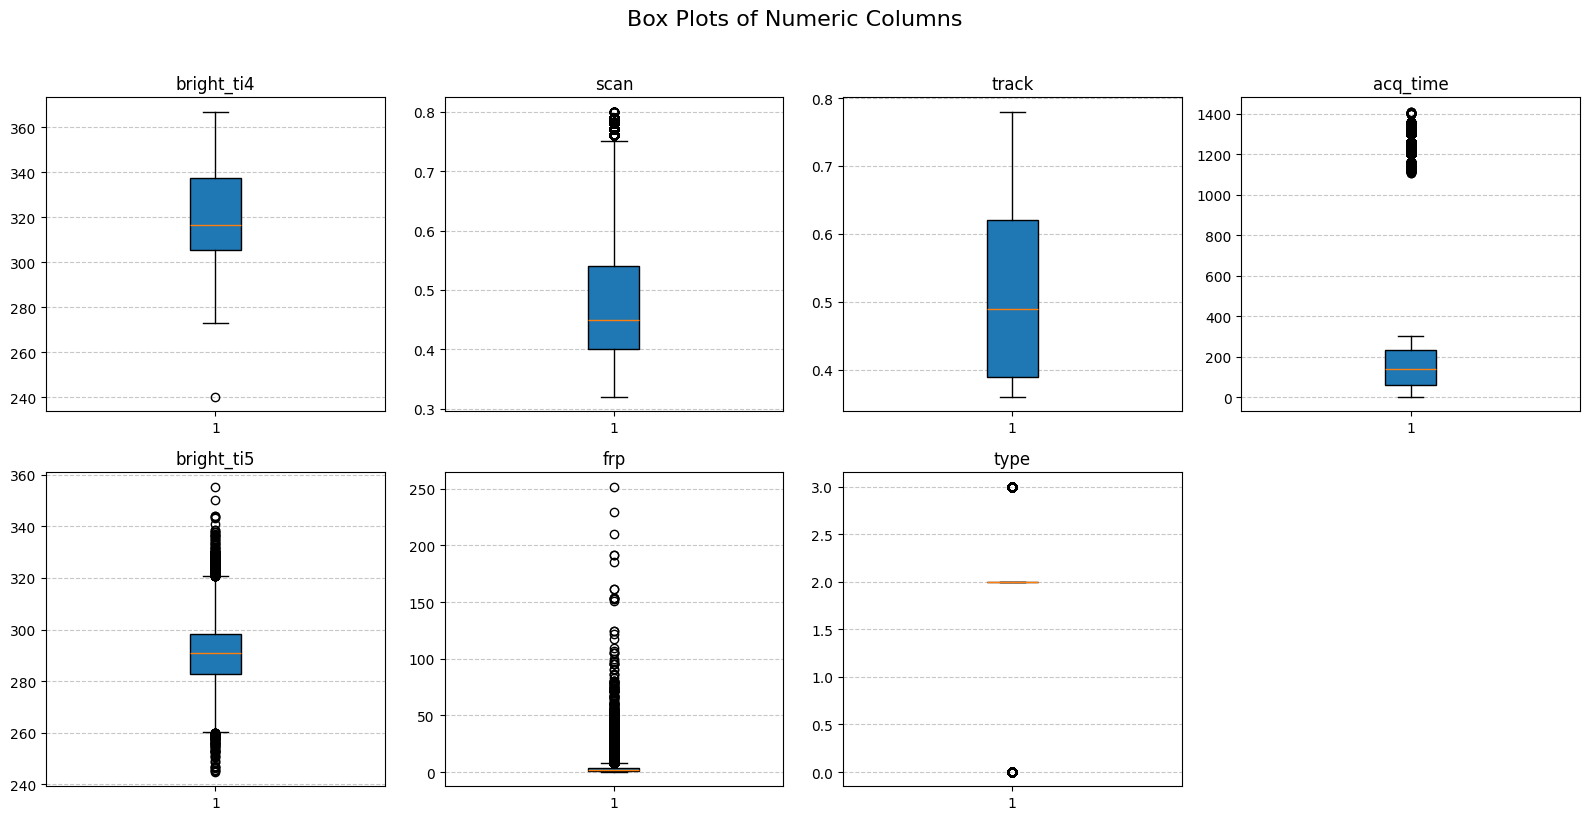

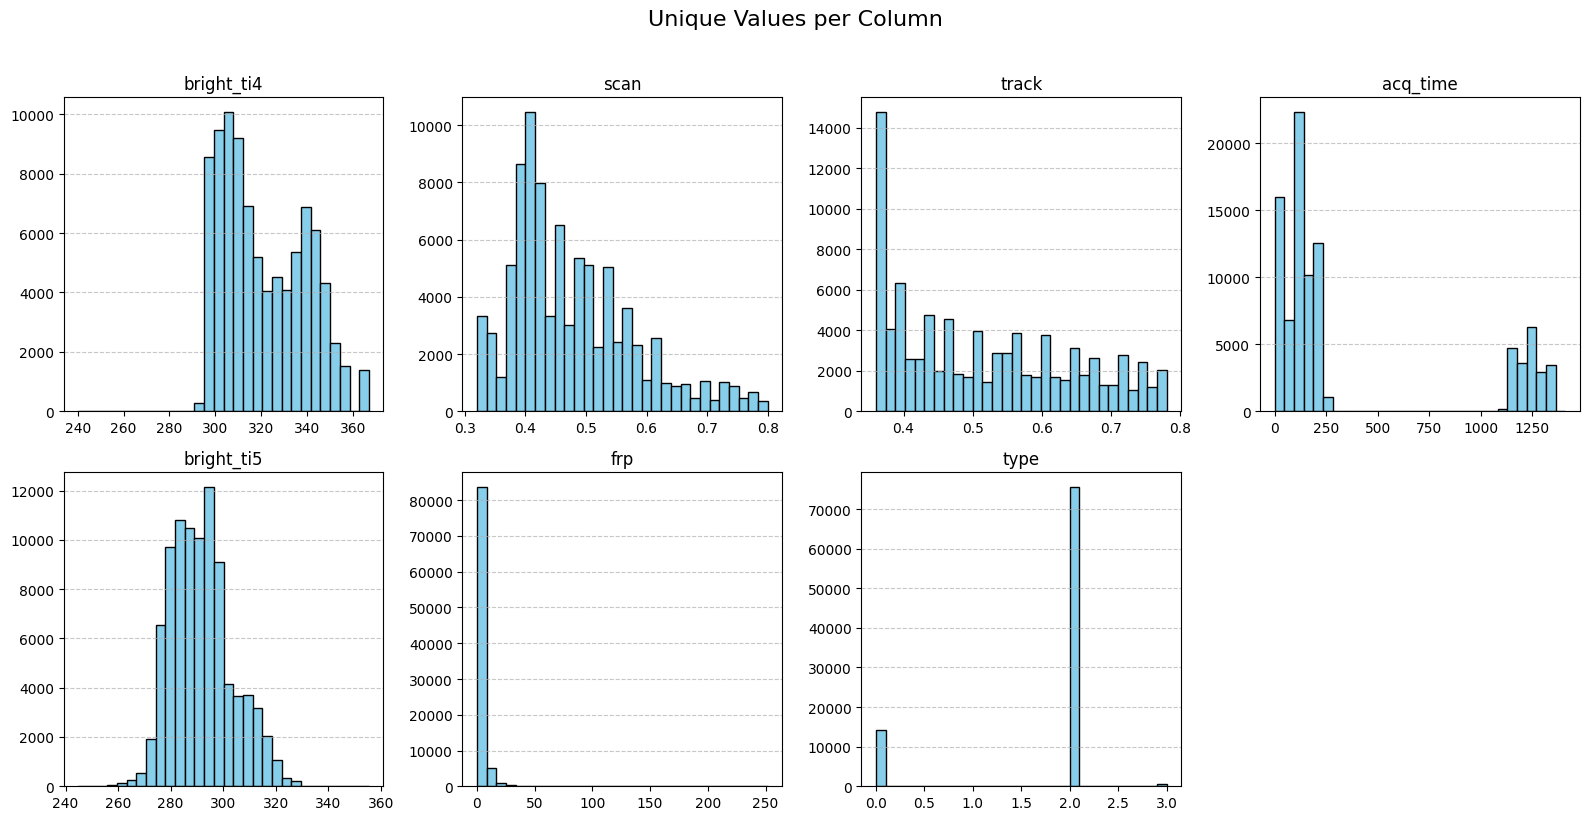

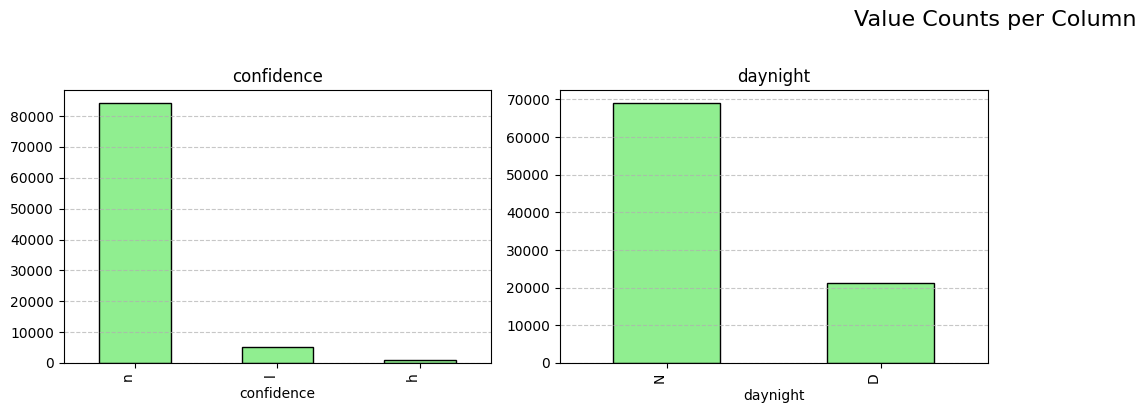

In [32]:
def plot_missing_values(all_cols):
    missing_values_percentage = all_cols.isnull().sum()
    old_number_of_rows = all_cols.shape[0]
    plt.figure(figsize=(8,4))
    missing_values_percentage.plot(kind='bar', color='salmon', edgecolor='black')
    new_number_of_rows = all_cols.dropna().shape[0]

    plt.title(f"Number of Missing Values per Column (before {old_number_of_rows}, after {new_number_of_rows})")
    plt.ylabel("Missing Values Count")
    plt.xlabel("Column")
    plt.xticks(rotation=90, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

cols_per_row = 4  # you can change to 3 or 5 depending on your screen

def plot_box_plots(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Box Plots of Numeric Columns", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.boxplot(numeric_cols[col], vert=True, patch_artist=True)
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_histograms(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Unique Values per Column", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.hist(numeric_cols[col], bins=30, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_bar_charts(nominal_cols):
    n = len(nominal_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 5, rows * 4))
    plt.suptitle("Value Counts per Column", fontsize=16, y=1.02)
    
    for i, col in enumerate(nominal_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        value_counts = nominal_cols[col].value_counts()
        value_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
        plt.title(col)
        plt.xticks(rotation=90, ha="right")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()



numeric_cols = all_cols.select_dtypes(include=["number"])
string_cols = all_cols.select_dtypes(include=["object"])

print("=== Numeric columns ===")
print(numeric_cols.dtypes)
print("=== String columns ===")
print(string_cols.dtypes)

plot_missing_values(dataset)
plot_box_plots(numeric_cols)
plot_histograms(numeric_cols)
plot_bar_charts(string_cols)



# Correlation matrix

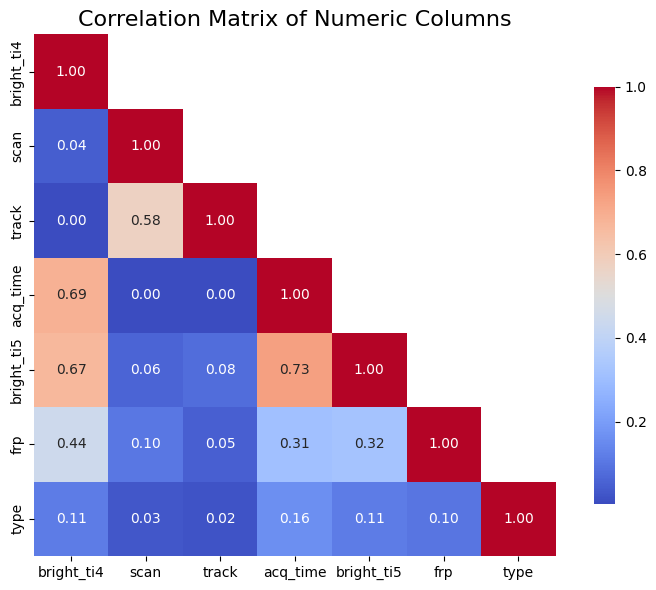

In [29]:

numeric_cols = numeric_cols.loc[:, numeric_cols.nunique() > 1]

# Correlation analysis
correlation_matrix = numeric_cols.corr().abs()

def plot_correlation_matrix(correlation_matrix):
    mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix of Numeric Columns", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(correlation_matrix)

# Export cleaned dataset

In [15]:
dataset.drop(columns=["acq_date", "acq_time", "confidence", "bright_ti4", "bright_ti5", "daynight", "frp"], inplace=True)

dataset = xarray.Dataset.from_dataframe(dataset)
dataset.to_netcdf(r"../local_dataset/dataset/fire_full.nc")

dataset = xarray.open_dataset(r"../local_dataset/dataset/fire_full.nc")
dataset = dataset.to_dataframe().reset_index(drop=True)

print(dataset.head())

        lat      lon  type
0  31.64847  9.16945     2
1  31.49290  9.48947     0
2  31.49524  9.49053     0
3  33.36728  8.54768     2
4  31.64812  9.17107     2
